In [1]:
import itertools

import numpy as np
from sklearn.datasets import make_blobs
import z3

import z3ml

# Data Generation

In [2]:
NUM_FEATURES = 2
NUM_CLASSES = 3
SEED = 42

In [3]:
X, y = make_blobs(n_features=NUM_FEATURES, centers=NUM_CLASSES, random_state=SEED)

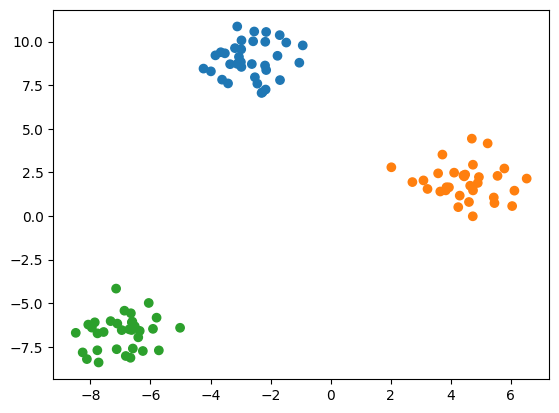

In [4]:
z3ml.visualize.plot(X, y);

# Fitting Models

sat
Model Parameters:
 w: [ 0.23427283 -0.01846165]
 b: [-0.10154311]


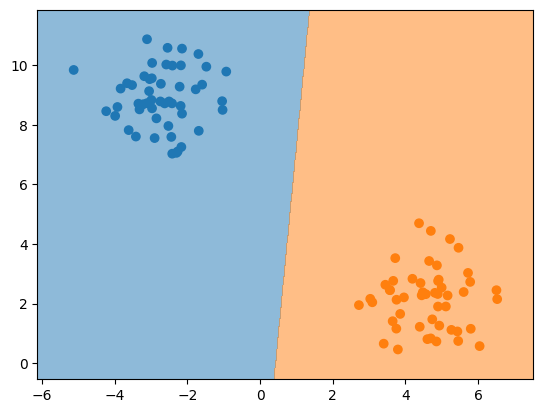

In [5]:
X, y = make_blobs(n_features=NUM_FEATURES, centers=2, random_state=SEED)

ml = z3ml.models.z3Linear(NUM_FEATURES)
constraints = z3ml.train.train(X, y, ml, z3ml.losses.threshold_loss)

s = z3.Solver()
s.add(*itertools.chain(*constraints))
status = s.check()
print(status)
if status == z3.sat:
    m = s.model()
    ml = ml.realize(m)
    print("Model Parameters:")
    print(f" w: {ml.parameters['w']}")
    print(f" b: {ml.parameters['b']}")

    z3ml.visualize.plot_boundry(X, y, ml.predict)
    z3ml.visualize.plot(X, y)

sat
Model Parameters:
 w: [1 0]
 b: [0]


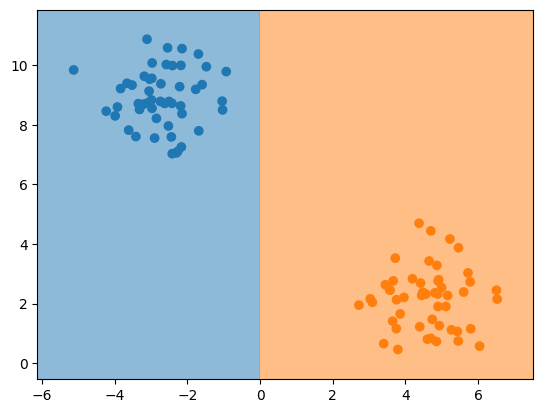

In [6]:
# Regenerate data so we can re-run cells in any order.
X, y = make_blobs(n_features=NUM_FEATURES, centers=2, random_state=SEED)
ml = z3ml.models.z3Linear(NUM_FEATURES, dtype=z3.Int)
constraints = z3ml.train.train(X, y, ml, z3ml.losses.threshold_loss)

s = z3.Solver()
s.add(*itertools.chain(*constraints))
status = s.check()
print(status)
if status == z3.sat:
    m = s.model()
    ml = ml.realize(m)
    print("Model Parameters:")
    print(f" w: {ml.parameters['w']}")
    print(f" b: {ml.parameters['b']}")

    z3ml.visualize.plot_boundry(X, y, ml.predict)
    z3ml.visualize.plot(X, y)

sat
Model Parameters:
 w: [[-0.03595402  0.0912965  -0.14070647]
 [ 0.09650958 -0.00918677 -0.004161  ]]
 b: [-1.02942246 -0.49105658 -1.12208881]


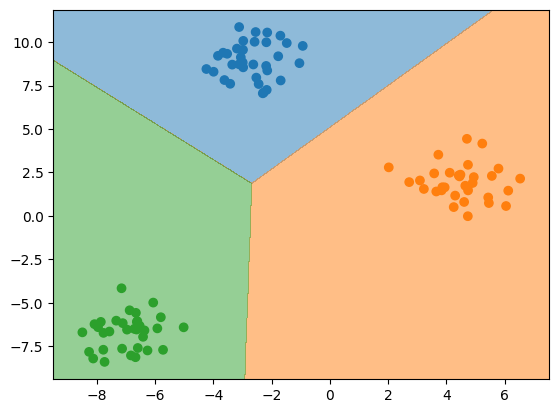

In [7]:
X, y = make_blobs(n_features=NUM_FEATURES, centers=NUM_CLASSES, random_state=SEED)

ml = z3ml.models.z3MultiClassLinear(NUM_FEATURES, NUM_CLASSES)
constraints = z3ml.train.train(X, y, ml, z3ml.losses.multiclass_loss)

s = z3.Solver()
s.add(*itertools.chain(*constraints))
status = s.check()
print(status)
if status == z3.sat:
  m = s.model()
  ml = ml.realize(m)
  print("Model Parameters:")
  print(f" w: {ml.parameters['w']}")
  print(f" b: {ml.parameters['b']}")

  z3ml.visualize.plot_boundry(X, y, ml.predict)
  z3ml.visualize.plot(X, y)

sat
Model Parameters:
 w: [[-11  -2   1]
 [ -2  -1 -27]]
 b: [ -2  -4 -19]


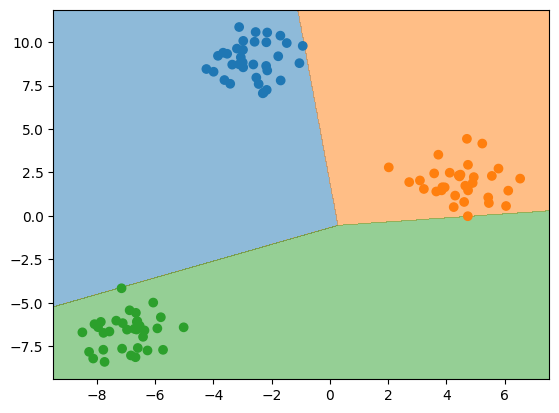

In [14]:
X, y = make_blobs(n_features=NUM_FEATURES, centers=NUM_CLASSES, random_state=SEED)

ml = z3ml.models.z3MultiClassLinear(NUM_FEATURES, NUM_CLASSES, dtype=z3.Int)
constraints = z3ml.train.train(X, y, ml, z3ml.losses.multiclass_loss)

s = z3.Solver()
s.add(*itertools.chain(*constraints))
status = s.check()
print(status)
if status == z3.sat:
  m = s.model()
  ml = ml.realize(m)
  print("Model Parameters:")
  print(f" w: {ml.parameters['w']}")
  print(f" b: {ml.parameters['b']}")

  z3ml.visualize.plot_boundry(X, y, ml.predict)
  z3ml.visualize.plot(X, y)

# Not Linearly Separable

## XOR

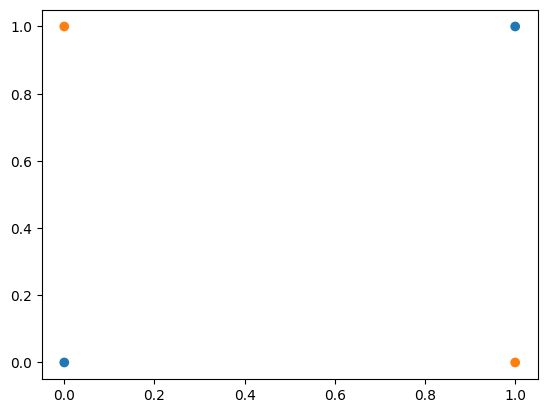

In [9]:
X = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]])
y = np.array([0, 1, 1, 0])

z3ml.visualize.plot(X, y);

In [10]:
ml = z3ml.models.z3MultiClassLinear(2, 2)
constraints = z3ml.train.train(X, y, ml, z3ml.losses.multiclass_loss)

s = z3.Solver()
s.add(*itertools.chain(*constraints))
print(s.check(), "as expected")

unsat as expected


sat
Model Parameters:
 ws: [array([[ -2,  -2, -19],
       [  2,  -2,  16]]), array([[22,  0],
       [ 0,  1],
       [-2,  1]])]
 bs: [array([1, 4, 2]), array([-10,   1])]


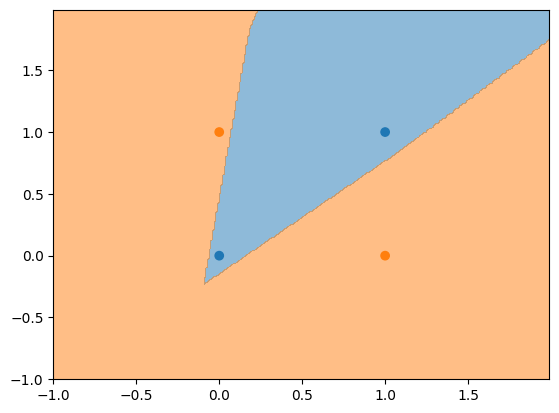

In [11]:
ml = z3ml.models.z3MLP(2, 3, 2, dtype=z3.Int)  # This took forever with dtype of Real
constraints = z3ml.train.train(X, y, ml, z3ml.losses.multiclass_loss)

s = z3.Solver()
s.add(*itertools.chain(*constraints))
status = s.check()
print(status)
if status == z3.sat:
    m = s.model()
    ml = ml.realize(m)

    print(f"Model Parameters:")
    print(f" ws: {ml.ws}")
    print(f" bs: {ml.bs}")

    z3ml.visualize.plot_boundry(X, y, ml.predict)
    z3ml.visualize.plot(X, y)

## A More Realistic Non-Separable Problem

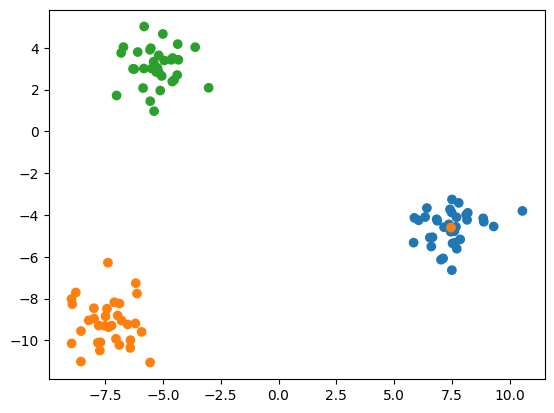

In [17]:
X, y = make_blobs(n_features=NUM_FEATURES, centers=NUM_CLASSES, random_state=128)

# Create a datapoint in the wrong cluster
X_ns = np.concatenate([X, np.mean(X[y == 0], axis=0, keepdims=True)], axis=0)
y_ns = np.concatenate([y, [1]], axis=0)

z3ml.visualize.plot(X_ns, y_ns);

In [25]:
ml = z3ml.models.z3MultiClassLinear(NUM_FEATURES, NUM_CLASSES)
constraints = z3ml.train.train(X_ns, y_ns, ml, z3ml.losses.multiclass_loss)

s = z3.Solver()
s.set(unsat_core=True)
for i, cs in enumerate(constraints):
  for j, c in enumerate(cs):
    if j == (len(cs) - 1):
      s.assert_and_track(c, f"d{i}")
    else:
      s.add(c)
print(s.check(), "as expected")

unsat as expected


There are 4 constraints in the UNSAT-core: [d100, d83, d5, d6]


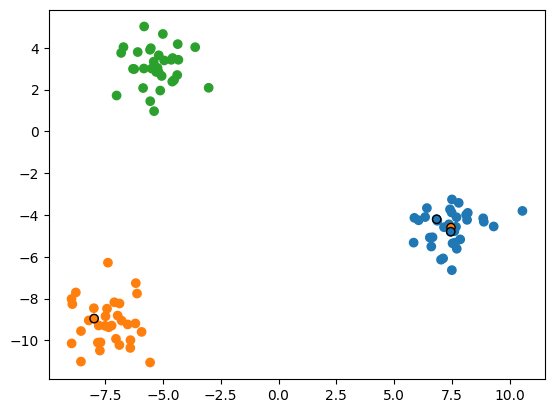

In [22]:
c = s.unsat_core()
print(f"There are {len(c)} constraints in the UNSAT-core: {c}")

unsat = [int(str(u)[1:]) for u in c]

z3ml.visualize.plot_unsat(X_ns, y_ns, unsat);

sat
Model Accuracy: 99.0099


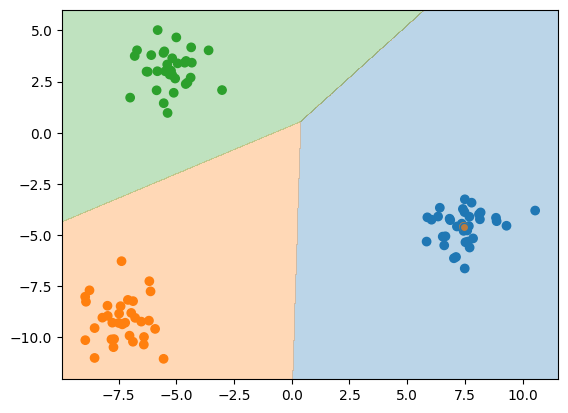

In [27]:
o = z3.Optimize()  # A MaxSAT solver, it takes longer
for i, cs in enumerate(constraints):
    for j, c in enumerate(cs):
        if j == (len(cs) - 1):
            o.add_soft(c)
        else:
            o.add(c)
status = o.check()
print(status)
if status == z3.sat:
    ml = ml.realize(o.model())
    y_hat = ml.predict(X_ns)
    print(f"Model Accuracy: {sum(y_hat == y_ns)/len(y_ns)*100:.4f}")

    z3ml.visualize.plot_predict(X_ns, y_ns, y_hat)
    z3ml.visualize.plot_boundry(X_ns, y_ns, ml.predict, alpha=0.3)

In [ ]:
# # Simple Scaling
# times = []
# num_examples = [2 ** i for i in range(16)]

# for num_ex in num_examples:
#     status = unsat
#     while status == unsat:
#         X, y = make_blobs(num_ex, n_features=NUM_FEATURES, centers=NUM_CLASSES)
#         ml = z3MultiClassLinear(NUM_FEATURES, NUM_CLASSES)
#         terms = train(X, y, ml, multiclass_loss)
#         s = Solver()
#         s.add(*itertools.chain(*terms))
#         tic = time.time()
#         status = s.check()
#         toc = time.time()
#     times.append(toc - tic)
#     print(f"Solved for {num_ex} examples.")